In [1]:
import os, gc
import pygrib
import numpy as np
import pandas as pd
import xarray as xr
import multiprocessing as mp
import matplotlib.pyplot as plt 

from glob import glob
from functools import partial
from matplotlib import gridspec
from datetime import datetime, timedelta

import regionmask
import cartopy
import cartopy.crs as ccrs
import geopandas as gpd

os.environ['OMP_NUM_THREADS'] = '1'
n_cores = 64

In [2]:
nbm_dir = '/scratch/general/lustre/u1070830/nbm/'
urma_dir = '/scratch/general/lustre/u1070830/urma/'
# tmp_dir = '/scratch/general/lustre/u1070830/tmp/'
# os.makedirs(tmp_dir, exist_ok=True)

In [3]:
start_date = datetime(2020, 11, 1, 0)
end_date = datetime(2021, 5, 25, 12)

In [7]:
urma_flist_raw = np.array(sorted([f for f in glob(urma_dir + '*.WR.grib2') if 'idx' not in f]))

# urma_datelist = [datetime.strptime(s.split('.')[1], '%Y%m%d%H') for s in urma_flist_raw]
urma_datelist = [datetime.strptime(s.split('.')[0].split('_')[-1], '%Y%m%d%H') for s in urma_flist_raw]

urma_index = np.array([i for i, d in enumerate(urma_datelist) if 
                 ((d >= start_date) & (d <= end_date))])

urma_flist = urma_flist_raw[urma_index]

print(len(urma_flist), ' URMA files to read')

789  URMA files to read


In [15]:
def open_urma(f, cfengine='cfgrib'):
    try:
        ds = xr.open_dataset(f, engine=cfengine)
        # ds['valid'] = datetime.strptime(f.split('/')[-1].split('.')[1], '%Y%m%d%H')
        ds['valid'] = datetime.strptime(f.split('/')[-1].split('.')[0].split('_')[-1], '%Y%m%d%H')

    except:
        return None
    else:
        return ds

In [17]:
with mp.get_context('fork').Pool(n_cores) as p:
    urma = p.map(open_urma, urma_flist, chunksize=1)
    p.close()
    p.join()

urma = [f for f in urma if f is not None]
urma = xr.concat(urma, dim='valid').rename({'tp':'apcp6h_mm', 
                                            #'xgrid_0':'x', 'ygrid_0':'y',
                                            'latitude':'lat', 'longitude':'lon'})

urma = urma['apcp6h_mm']
urma = urma.drop(['time', 'surface', 'valid_time'])

In [18]:
urma

<xarray.DataArray 'apcp6h_mm' (valid: 789, y: 1051, x: 1132)>
array([[[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        ...,
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ]],

       [[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        ...,
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ]],

       [[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        ...,
...
        [0.875 , 1.    , 1.    , ..., 0.    , 0.    , 0.125 ],
        [1.    , 1.125 , 1.125 , ..., 0.    , 0.    , 0.125 ],
        [1.125 , 1.1875, 1.1875, ..., 0.    , 0.    , 0.    ]],

       [[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        ...,
        [0.5   , 0.5   , 0.5   , ...,    nan,    nan, 0.    ],
        [0.375 , 0.5   , 0.5   , ...,    nan,    nan, 0.    ],
        [0.25  , 0.375 , 0.5   , ...,    nan,    nan,    nan]],

       [[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        ...,
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    ,    nan, 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    ,    nan,    nan]]],
      dtype=float32)
Coordinates:
    step     timedelta64[ns] 06:00:00
    lat      (y, x) float64 26.48 26.48 26.49 26.49 ... 52.77 52.77 52.77 52.77
    lon      (y, x) float64 231.8 231.8 231.9 231.9 ... 259.7 259.8 259.8 259.8
  * valid    (valid) datetime64[ns] 2020-11-01 ... 2021-05-17
Dimensions without coordinates: y, x
Attributes:
    GRIB_paramId:                             228228
    GRIB_shortName:                           tp
    GRIB_units:                               kg m**-2
    GRIB_name:                                Total Precipitation
    GRIB_dataType:                            an
    GRIB_missingValue:                        9999
    GRIB_numberOfPoints:                      1189732
    GRIB_typeOfLevel:                         surface
    GRIB_NV:                                  0
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    GRIB_gridType:                            lambert
    GRIB_gridDefinitionDescription:           Lambert Conformal can be secant...
    GRIB_LaDInDegrees:                        25.0
    GRIB_LoVInDegrees:                        265.0
    GRIB_iScansNegatively:                    0
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    1
    GRIB_latitudeOfFirstGridPointInDegrees:   26.477743
    GRIB_latitudeOfSouthernPoleInDegrees:     -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  231.816181
    GRIB_longitudeOfSouthernPoleInDegrees:    0.0
    GRIB_DyInMetres:                          2539.703
    GRIB_DxInMetres:                          2539.703
    GRIB_Latin2InDegrees:                     25.0
    GRIB_Latin1InDegrees:                     25.0
    GRIB_Ny:                                  1051
    GRIB_Nx:                                  1132
    long_name:                                Total Precipitation
    units:                                    kg m**-2

In [19]:
urma24_compiled = []
for ihr in [0, 12]:

    urma24 = []
    print('IC/Missing 24h period ending: %02d Z'%ihr)

    date_range = pd.date_range(
        pd.to_datetime(urma.valid[0].values) + timedelta(hours=ihr), 
        urma.valid[-1].values, 
        freq='24H')

    for date in date_range:

        date0 = date - timedelta(hours=18)

        date_select = urma.sel(valid=slice(date0, date))
        n_select = date_select.valid.size

        if n_select == 4:
            date_select = date_select.sum(dim=['valid'])
            date_select['valid'] = date
            urma24.append(date_select)

        else:
             print(date)

    urma24 = xr.concat(urma24, dim='valid').rename('apcp24h_mm')
    print()
    
    os.makedirs(urma_dir + 'agg/', exist_ok=True)
    urma24.to_netcdf(urma_dir + 'agg/urma_agg.%02dz.nc'%ihr)
    
    urma24_compiled.append(urma24)
    del urma24

IC/Missing 24h period ending: 00 Z
2020-11-01 00:00:00

IC/Missing 24h period ending: 12 Z
2020-11-01 12:00:00



In [20]:
urma24 = xr.concat(urma24_compiled, dim='valid').sortby('valid')
urma24.to_netcdf(urma_dir + 'agg/urma_agg.nc')

In [ ]:
print('New URMA saved out...')
urma24

In [21]:
urma24 = xr.open_dataset(urma_dir + 'agg/urma_agg.nc')['apcp24h_mm']

urma24 = urma24 / 25.4
urma24 = urma24.rename('apcp24h_in')
urma24['lon'] = urma24['lon'] - 360

In [22]:
urma24

<xarray.DataArray 'apcp24h_in' (valid: 393, y: 1051, x: 1132)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.01968504, 0.01968504, 0.01968504, ..., 0.        ,
         0.        , 0.        ],
        [0.01968504, 0.01968504, 0.01968504, ..., 0.        ,
         0.        , 0.        ],
        [0.01968504, 0.01968504, 0.01968504, ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.03444882, 0.03937008, 0.03937008, ..., 0.        ,
         0.        , 0.00492126],
        [0.04429134, 0.04429134, 0.04429134, ..., 0.        ,
         0.        , 0.00492126],
        [0.0492126 , 0.05167323, 0.05167323, ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.05167323,
         0.03937008, 0.03198819],
        [0.        , 0.        , 0.        , ..., 0.04675197,
         0.03690945, 0.03444882],
        [0.        , 0.        , 0.        , ..., 0.04675197,
         0.03937008, 0.03690945],
        ...,
        [0.05413386, 0.05905512, 0.05905512, ..., 0.        ,
         0.        , 0.00492126],
        [0.05905512, 0.06397638, 0.06397638, ..., 0.        ,
         0.        , 0.00492126],
        [0.05905512, 0.06643701, 0.07135827, ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
    step     timedelta64[ns] ...
    lat      (y, x) float64 ...
    lon      (y, x) float64 -128.2 -128.2 -128.1 -128.1 ... -100.2 -100.2 -100.2
  * valid    (valid) datetime64[ns] 2020-11-02 ... 2021-05-17
Dimensions without coordinates: y, x

In [23]:
cwa = 'WESTUS'
produce_thresholds = [0.01, 0.10, 0.25, 0.5, 1., 2., 4.]

In [24]:
# Masking with regionmask
lons, lats = urma24.lon, urma24.lat

geodir = '../forecast-zones/'
zones_shapefile = glob(geodir + '*.shp')[0]

# Read the shapefile
zones = gpd.read_file(zones_shapefile)

# Prune to Western Region using TZ
zones = zones.set_index('TIME_ZONE').loc[['M', 'Mm', 'm', 'MP', 'P']].reset_index()
cwas = zones.dissolve(by='CWA').reset_index()[['CWA', 'geometry']]
_cwas = cwas.copy()

if cwa == 'WESTUS':
    _cwas['CWA'] = 'WESTUS'
    _cwas = _cwas.dissolve(by='CWA').reset_index()
    bounds = _cwas.total_bounds
else:
    bounds = _cwas[_cwas['CWA'] == cwa].bounds.values[0]
        
mask = regionmask.mask_3D_geopandas(_cwas, lons, lats).rename({'region':'cwa'})
mask['cwa'] = _cwas.iloc[mask.cwa]['CWA'].values.astype(str)
mask = mask.sel(cwa=cwa)

idx = np.where(
    (lats >= bounds[1]) & (lats <= bounds[3]) &
    (lons >= bounds[0]) & (lons <= bounds[2]))

mask = mask.isel(y=slice(idx[0].min(), idx[0].max()), x=slice(idx[1].min(), idx[1].max()))
urma24_trim = urma24.isel(y=slice(idx[0].min(), idx[0].max()), x=slice(idx[1].min(), idx[1].max()))
urma24_trim = urma24_trim.transpose('valid', 'y', 'x')

_, mask = xr.broadcast(urma24_trim, mask)

urma24_trim['x'] = mask.x
urma24_trim['y'] = mask.y

urma24_masked = xr.where(mask, urma24_trim, np.nan)

In [25]:
print(cwa)

for threshold in produce_thresholds:
    
    # nn = xr.where(~np.isnan(urma24_masked), 1, 0).sum(dim='valid')
    nn = xr.where(mask, 1, 0).sum(dim='valid')

    qpe_orf = xr.where(urma24_masked >= threshold, 1, 0).sum(dim='valid')/nn
    
    print('%.2f'%threshold, qpe_orf.mean().values.round(4))

WESTUS
0.01 0.2265
0.10 0.1107
0.25 0.0552
0.50 0.0248
1.00 0.0078
2.00 0.0014
4.00 0.0001


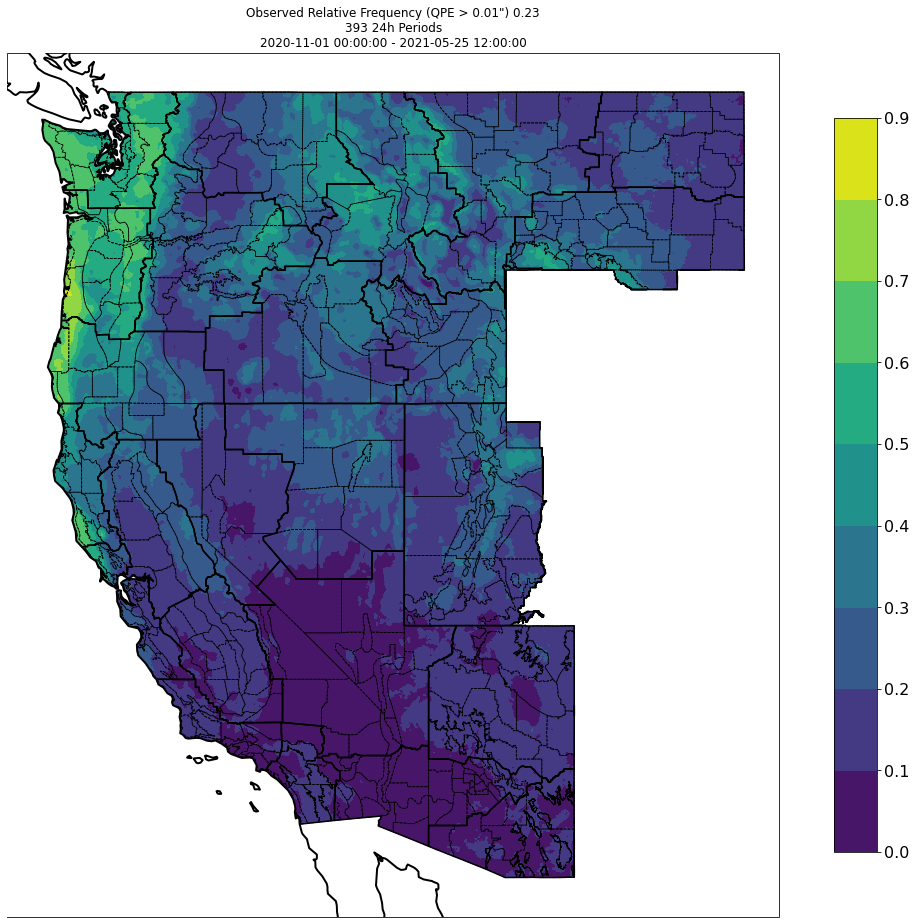

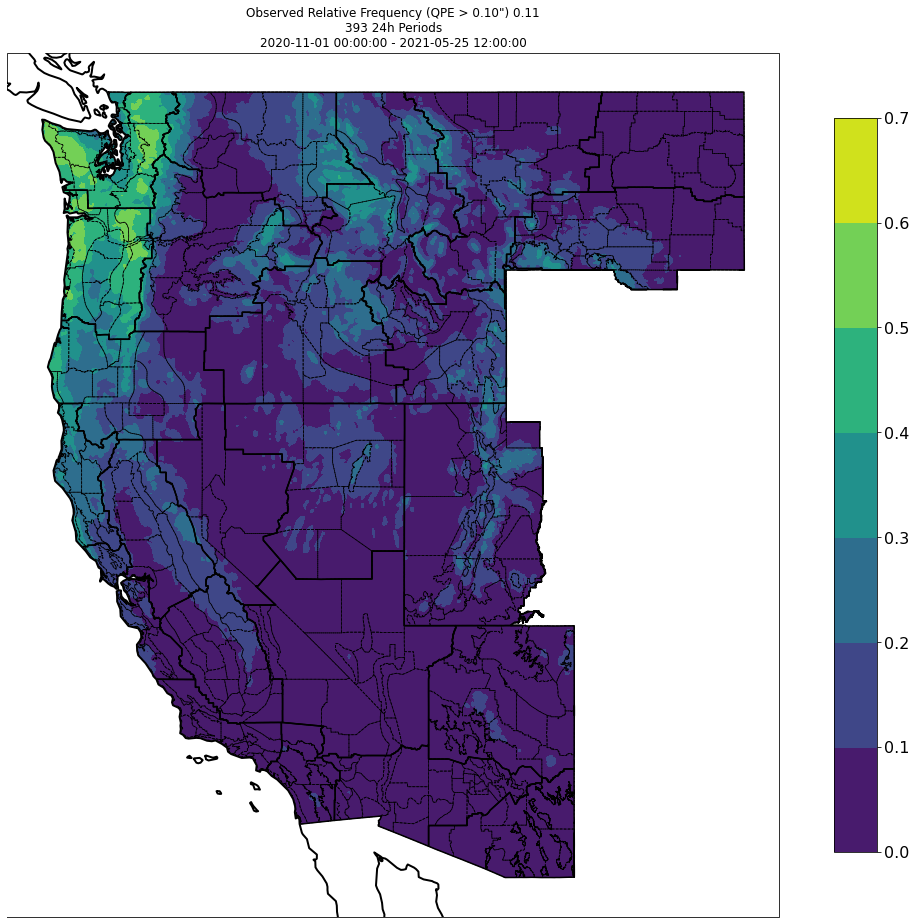

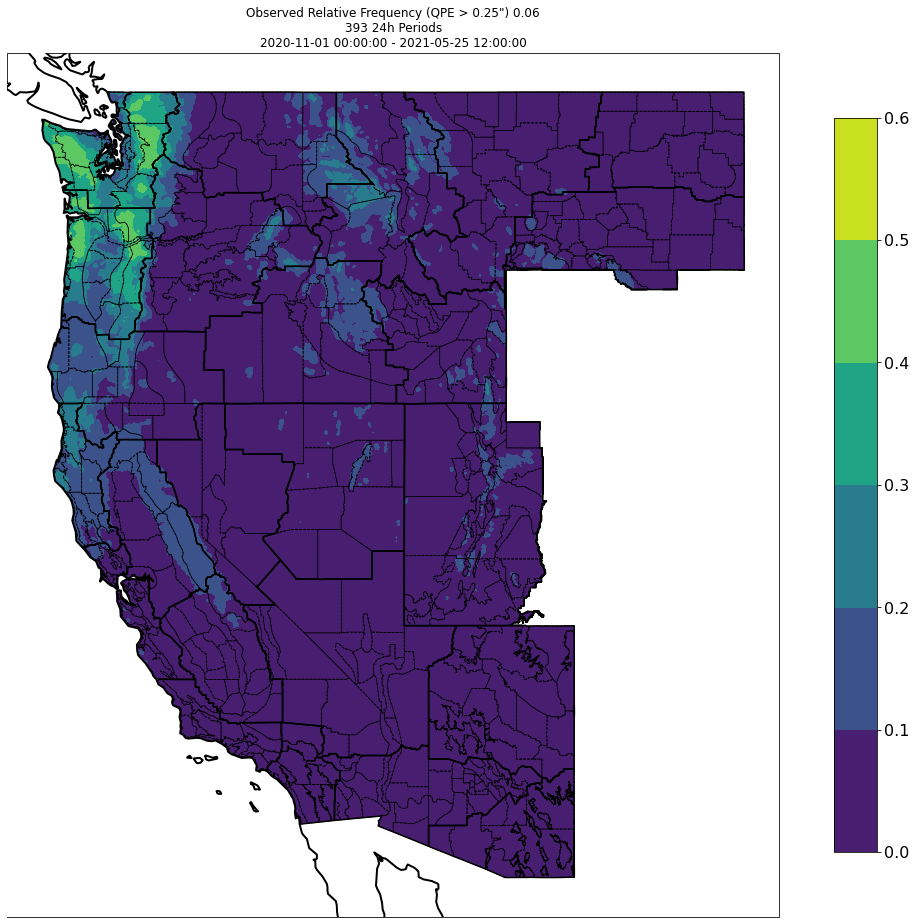

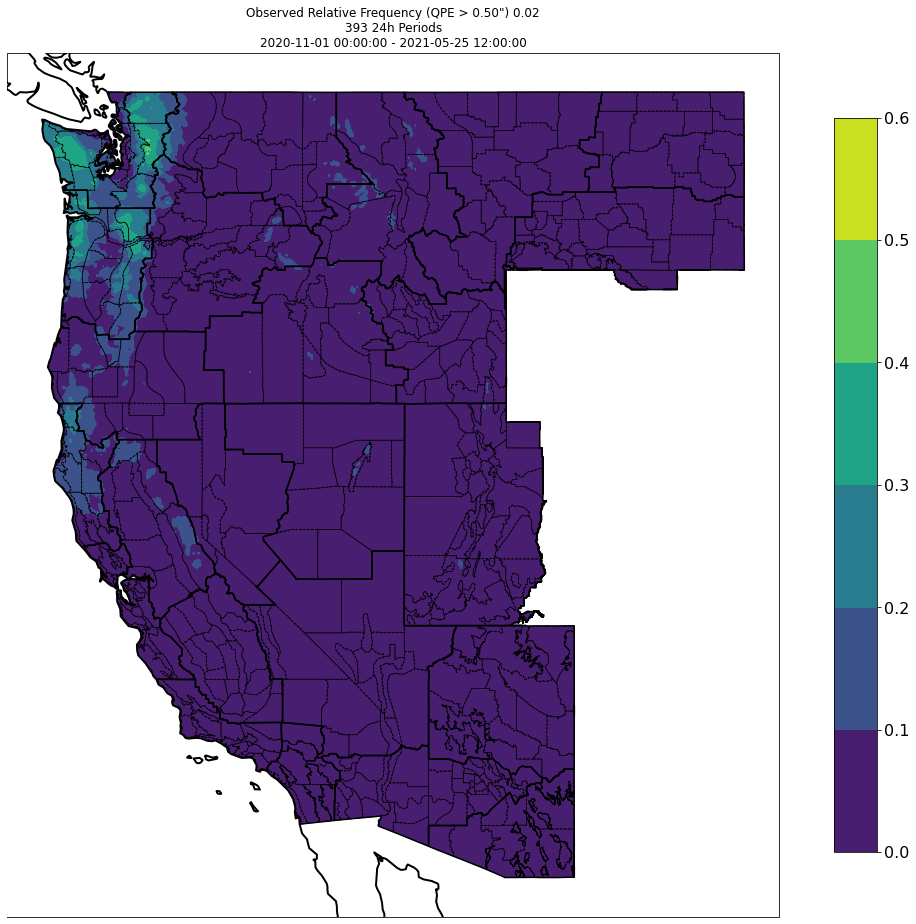

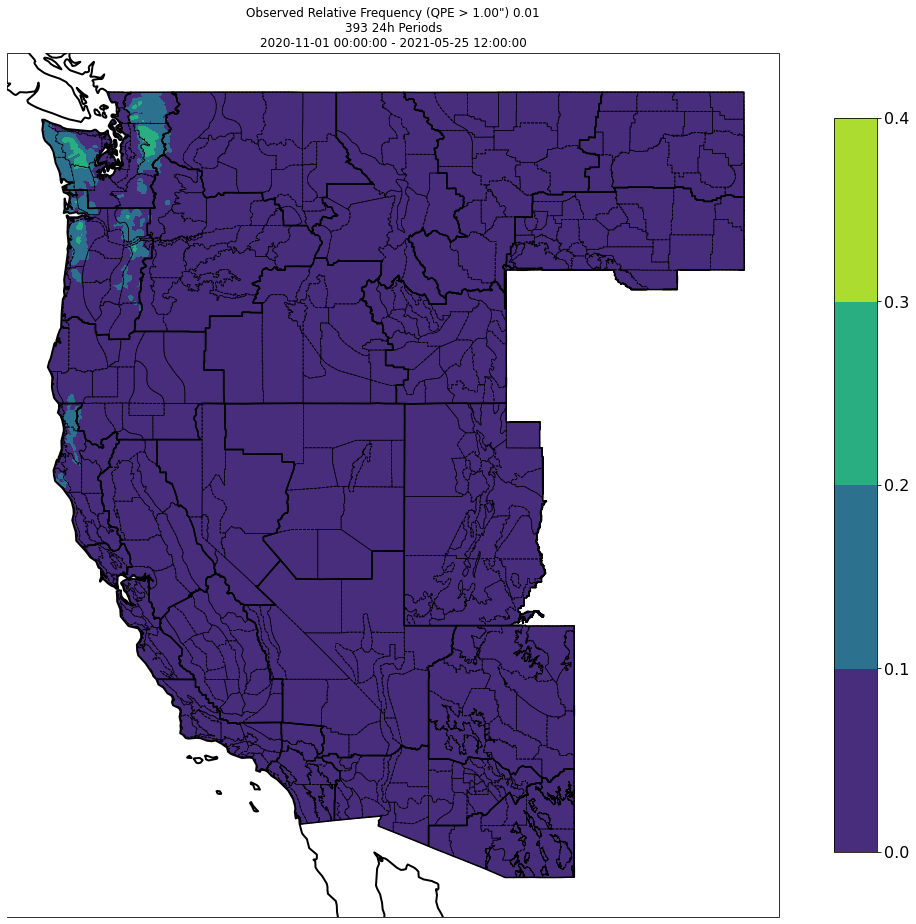

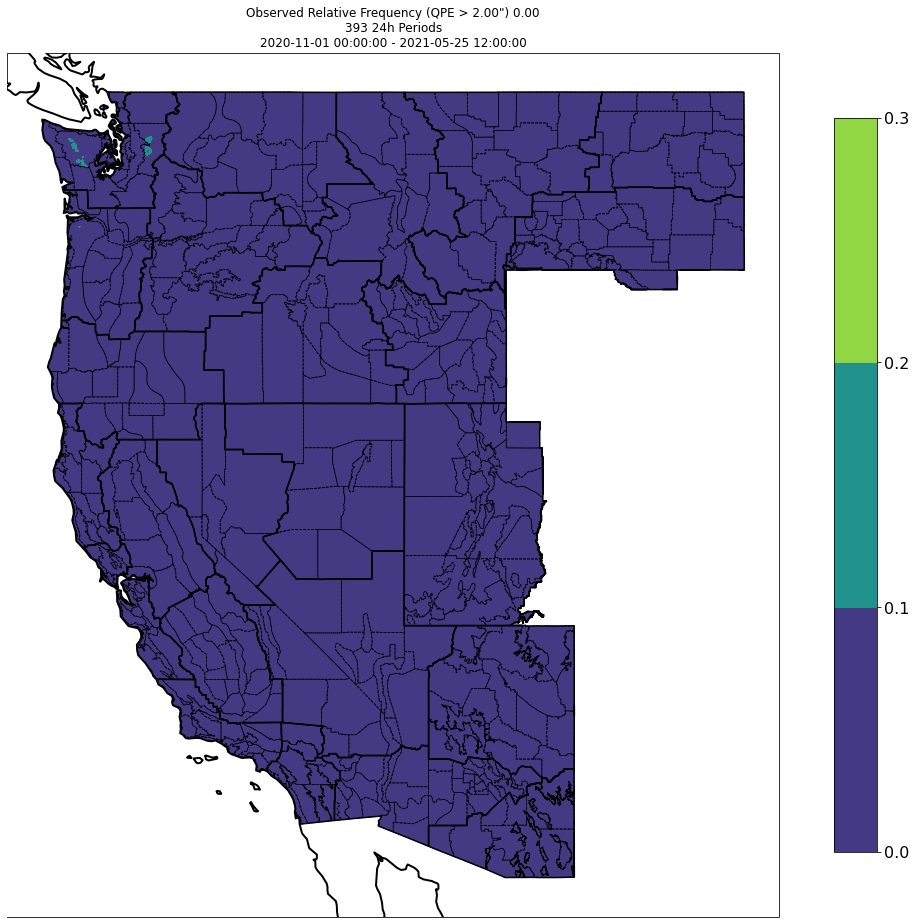

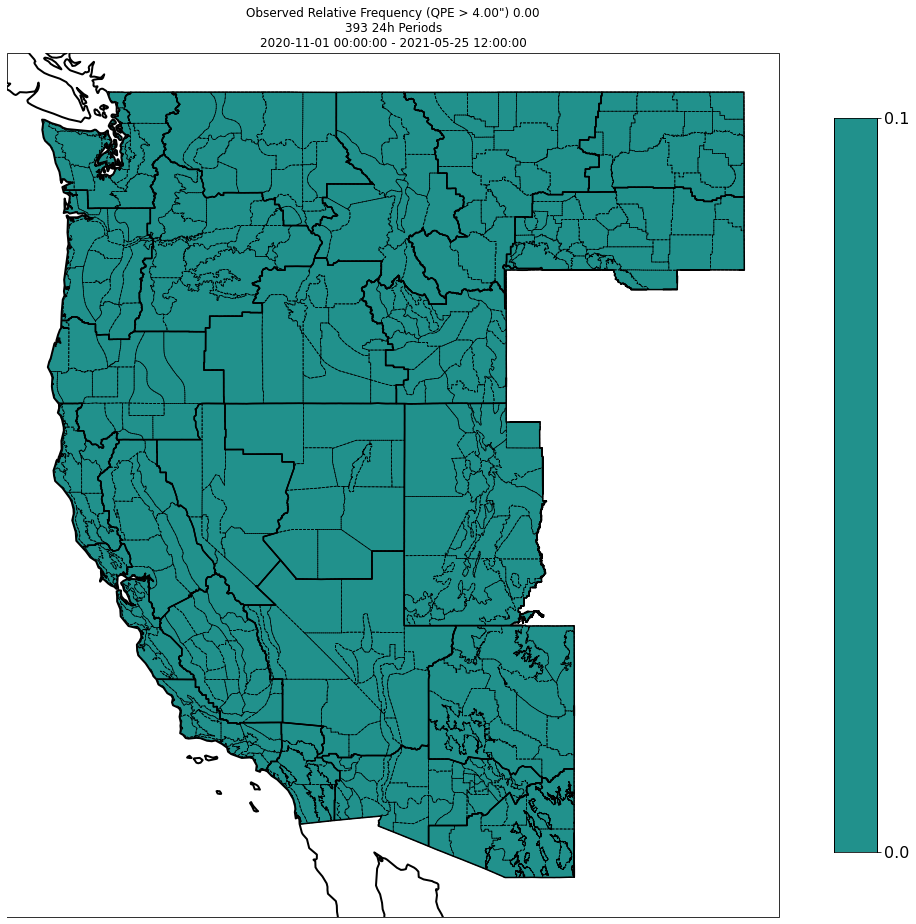

In [26]:
for threshold in produce_thresholds:

    # Make the plot
    fig = plt.figure(figsize=(12, 12), facecolor='w')
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

    zones.geometry.boundary.plot(color=None, linestyle='--', edgecolor='black', 
                                 linewidth=0.75, ax=ax)

    cwas.geometry.boundary.plot(color=None, edgecolor='black', linewidth=1.5, ax=ax)
    ax.add_feature(cartopy.feature.OCEAN, zorder=100, color='w', edgecolor=None)
    ax.coastlines(linewidth=2, zorder=101)

    # nn = xr.where(~np.isnan(urma24_masked), 1, 0).sum(dim='valid')
    nn = xr.where(mask, 1, 0).sum(dim='valid')

    qpe_orf = xr.where(urma24_masked >= threshold, 1, 0).sum(dim='valid')/nn

    ax.set_title('Observed Relative Frequency (QPE > %0.2f") %.2f\n'%(threshold, qpe_orf.mean()) + 
                 '%d 24h Periods\n%s - %s'%(mask.shape[0], start_date, end_date))
    cbd = ax.contourf(urma24_masked.lon, urma24_masked.lat, qpe_orf,
               levels=np.arange(0, qpe_orf.max().round(1)+.2, .1))

    cbar_ax = fig.add_axes([1.01, .075, .05, .85])
    cbar = plt.colorbar(cbd, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=16)
    
    plt.show()
    print()